In [68]:
%matplotlib notebook
import matplotlib.pyplot as plt

import numpy as np
from scipy import pi
from arc import Cesium
from scipy.optimize import curve_fit
tau = 2*pi

In [2]:
from basics import *
from rabi_frequencies import *
from atomic_physics import *
from hybrid_matrix_elements import *

In [35]:
p_ge = 75e-3  # W
p_er = 19e-3  # W
w_ge = 9e-6  # m
w_er = 5.4e-6  # m
pol_ge = SphericalVector([0,1,0], spherical_basis=True)  # sigma_+ polarized
pol_er = SphericalVector([0,0,1])  # sigma_- polarized
k_ar = SphericalVector([1,0,0], spherical_basis=True)  # z polarized
nr = 52  # Target Rydberg State
phi_ge = 0  # phase on 684nm field
phi_er = 0  # phase of 595nm field

bias_B = 5 * gauss # bias field in the z-direction

# Possible laser detunings from unperturbed intermediate states
det = -80

detuning = tau*det*1e6  # detuning from 4-6' line
delta = np.array([detuning - DET for DET in DHF])

In [57]:
delta*1e-6/tau

array([ -80.        -1.59154943e-07j, -504.80909457+0.00000000e+00j,
       -462.32      +0.00000000e+00j, -398.58976861+0.00000000e+00j,
       -313.62249296+0.00000000e+00j, -207.42362978+0.00000000e+00j,
        -80.        +0.00000000e+00j])

In [58]:
O_ge = np.zeros((7,15), dtype=complex)  # ground-to-excited rabi frequencies
O_er = np.zeros((7,15,4), dtype=complex)  # excited-to-rydberg rabi frequencies

z_g = zeeman_g(bias_B)
z_e = np.zeros((7,15), dtype=float)  # zeeman shift on each of the states in the excited manifold
z_r = np.zeros(4, dtype=float)  # zeeman shift on each of the states in the Rydberg manifold

for fp in range(1,7):
    for mp in range(-fp, fp+1):
        O_ge[fp,mp] = q_rabi_frequency(p_ge, w_ge, pol_ge, k_ar, q_rad_int, fp, mp, phi = phi_ge)
        z_e[fp,mp] = zeeman_e(bias_B, fp, mp)
        for i, mr in enumerate(np.arange(-3/2,3/2+1,1)):
            O_er[fp,mp,i] = d_rabi_frequency(p_er, w_er, pol_er, nr, fp, mp, mr, phi = phi_er)
            z_r[i] = zeeman_R(bias_B, nr, mr)

In [59]:
rabi = np.zeros(4, dtype = complex)
AC_stark = np.zeros(4, dtype = complex)
p_scatter = np.zeros(4, dtype = complex)

for i, mr in enumerate(np.arange(-3/2,3/2+1,1)):
    for fp in range(1,7):
        for mp in range(-fp, fp+1):
            d = delta[fp]-z_e[fp,mp]
            if fp == 6:
                print(f"g to |{fp},{mp}> to |{mr}>")
                #print(f"\t{d*1e-6/tau} - {d*1e-6/tau} Mhz")
                print(f"\tOmega_ge({fp},{mp}) = {O_ge[fp,mp]*1e-6/tau:.2f} MHz")
                print(f"\tOmega_er({fp},{mp}|mr={mr}) = {O_er[fp,mp,i]*1e-6/tau:.2f} MHz")
                con = (O_ge[fp,mp]*O_er[fp,mp,i])/(2)
                print(f"\tRabi Contribution = {con*1e-12/tau} MHz^2")
            rabi[i] += (O_ge[fp,mp]*O_er[fp,mp,i])/(2 * d)
            AC_stark[i] += (O_ge[fp,mp]*O_ge[fp,mp].conjugate() - O_er[fp,mp,i]*O_er[fp,mp,i].conjugate())/(4 * d)
            p_scatter[i] += gamma_e * (O_ge[fp,mp]*O_ge[fp,mp].conjugate() + O_er[fp,mp,i]*O_er[fp,mp,i].conjugate())/(2 * d)**2
    t_pi = pi/np.absolute(rabi[i])
    p_scatter[i] *= t_pi

g to |6,-6> to |-1.5>
	Omega_ge(6,-6) = 0.00+0.00j MHz
	Omega_er(6,-6|mr=-1.5) = 0.00+0.00j MHz
	Rabi Contribution = 0j MHz^2
g to |6,-5> to |-1.5>
	Omega_ge(6,-5) = 0.00+0.00j MHz
	Omega_er(6,-5|mr=-1.5) = 0.00+0.00j MHz
	Rabi Contribution = 0j MHz^2
g to |6,-4> to |-1.5>
	Omega_ge(6,-4) = 0.00+0.00j MHz
	Omega_er(6,-4|mr=-1.5) = -2.30+0.00j MHz
	Rabi Contribution = 0j MHz^2
g to |6,-3> to |-1.5>
	Omega_ge(6,-3) = 0.00+0.00j MHz
	Omega_er(6,-3|mr=-1.5) = -3.33+0.00j MHz
	Rabi Contribution = 0j MHz^2
g to |6,-2> to |-1.5>
	Omega_ge(6,-2) = 0.00+0.00j MHz
	Omega_er(6,-2|mr=-1.5) = -3.85+0.00j MHz
	Rabi Contribution = 0j MHz^2
g to |6,-1> to |-1.5>
	Omega_ge(6,-1) = 0.00-23.86j MHz
	Omega_er(6,-1|mr=-1.5) = -3.93+0.00j MHz
	Rabi Contribution = 294.5789824974835j MHz^2
g to |6,0> to |-1.5>
	Omega_ge(6,0) = 0.00+0.00j MHz
	Omega_er(6,0|mr=-1.5) = -3.64+0.00j MHz
	Rabi Contribution = 0j MHz^2
g to |6,1> to |-1.5>
	Omega_ge(6,1) = 0.00+0.00j MHz
	Omega_er(6,1|mr=-1.5) = -3.04+0.00j MHz
	Rabi

In [60]:
rabi*1e-6/tau

array([0.-0.59385575j, 0.-1.10855673j, 0.-0.6167529j , 0.+0.00415201j])

In [61]:
alpha684 = np.zeros(4,dtype=float)
alpha595 = np.zeros(4,dtype=float)

for i, mr in enumerate(np.arange(-3/2,3/2+1,1)):
    for fp in range(1,7):
        for mp in range(-fp, fp+1):
            d = delta[fp]-z_e[fp,mp]

            # rabi frequency per unit electric field strength (V/m)
            Oq = quadrupole_rabi_frequency(1,freq(684e-9),pol_ge,k_ar,q_rme_hf_h(q_rad_int,fp),4,0,fp,mp)
            Od = dipole_hf_to_fs(1,pol_er,d_rme_fs(52),5/2,fp,mp,3/2,mr,7/2)/np.sqrt(8)
            #print(1e-6*(O_ge[fp,mp]*O_ge[fp,mp].conjugate() - O_er[fp,mp,i]*O_er[fp,mp,i].conjugate())/(4 * d)/tau)
            #print(1e-6*(abs(Oq*electric_field_strength(p_ge,w_ge))**2/4/d-abs(Od*electric_field_strength(p_er,w_ge))**2/4/d)/tau)
            alpha684[i] += abs(Oq)**2/(4*d)
            alpha595[i] += abs(Od)**2/(4*d)

<ipython-input-61-b01f760e2f6c>:14: ComplexWarning: Casting complex values to real discards the imaginary part
  alpha684[i] += abs(Oq)**2/(4*d)


In [62]:
w_er2 = w_er
Lz = lambda z,zr: 1/(1+z**2/zr**2)
rabi_detuning = 0

Orm = rabi[1]
tpi = pi/abs(Orm)
zr1 = pi*w_ge**2/684e-9
zr2 = pi*w_er2**2/585e-9

alphaQ = alpha684[-1]
alphaD = alpha595[-1]

o_ge = lambda x,y,z : np.sqrt(Lz(z,zr1)*np.exp(-2*(x**2+y**2)*Lz(z,zr1)/w_ge**2))
o_er = lambda x,y,z : np.sqrt(Lz(z,zr2)*np.exp(-2*(x**2+y**2)*Lz(z,zr2)/w_er2**2))

Or = lambda x,y,z,x0,y0,z0,vz: Orm*o_ge(x-x0,y-y0,z-z0)*o_er(x,y,z)/(1+vz*freq(684e-9)/(c*det*1e6))

P_g = lambda t,O,D : 1-abs(O)**2/(abs(O)**2+abs(D)**2)*np.sin(np.sqrt(abs(O)**2+abs(D)**2)*t/2)**2

In [63]:
Orm

-6965267.382467293j

In [64]:
EQms = electric_field_strength(p_ge,w_ge)**2  # max electric field strength in 684nm, squared
EDms = electric_field_strength(p_er,w_er)**2  # max electric field strength in 595nm, squared

# relative AC stark shifts away from field maxima, (and atom mean location)
Dac_rel = lambda x,y,z,x0,y0,z0: alphaQ*EQms*(1-o_ge(x,y,z)**2)-alphaD*EDms*(o_er(x0,y0,z0)**2-o_er(x-x0,y-y0,z-z0)**2)

In [87]:
# atom and trap temperature
U0 = 600e-6
T = 15e-6

#FORT
wF = 2.6e-6
zfF = (pi*wF**2)/938e-9

sigX = 0.5*wF*np.sqrt(T/U0)
sigZ = zfF*np.sqrt(T/2/U0)
sigV = np.sqrt(kb*T/mcs)

N = 10000

rnd = np.random.default_rng()
Xs = rnd.normal(0,sigX,N)
Ys = rnd.normal(0,sigX,N)
Zs = rnd.normal(0,sigZ,N)
Vzs = rnd.normal(0,sigV,N)

ts = np.linspace(0,50*tpi,500)

P_gf = lambda x,y,z,t,x0,y0,z0,vz,D: P_g(
    t,
    Or(x,y,z,x0,y0,z0,vz),
    D
)

<IPython.core.display.Javascript object>


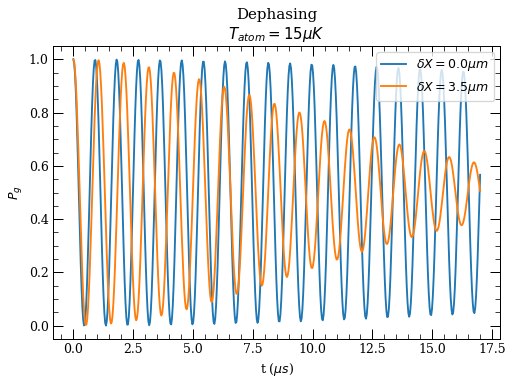

In [137]:
sigX = 0.5*wF*np.sqrt(T/U0)
sigZ = zfF*np.sqrt(T/2/U0)
sigV = np.sqrt(kb*T/mcs)

N = 10000

rnd = np.random.default_rng()
Xs = rnd.normal(0,sigX,N)
Ys = rnd.normal(0,sigX,N)
Zs = rnd.normal(0,sigZ,N)
Vzs = rnd.normal(0,sigV,N)


fig,ax=plt.subplots(1,1)
for X0b in [0,0.38698613030623186]:
    Ps = [
        P_gf(
            Xs,
            Ys,
            Zs,
            t,
            w_ge*X0b,
            0,
            0,
            Vzs,
            Dac_rel(Xs,Ys,Zs,w_ge*X0b,0,0)
        ).mean() for t in ts
    ]
    ax.plot(ts*1e6,Ps,label=f"$\delta X = {X0b*w_ge*1e6:.1f}\mu m$")
ax.legend()

ax.set_xlabel("t ($\mu s$)")
ax.set_ylabel("$P_g$")
ax.set_title(f"Dephasing\n$T_{{atom}} = {T*1e6:.0f}\mu K$")

fig.tight_layout()
fig.show()
#fig.savefig(f"Rydberg Rabi Dephasing, T = {T*1e6:.0f}uK.png")

<IPython.core.display.Javascript object>


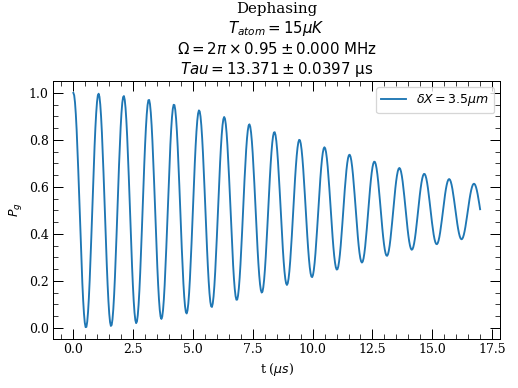

In [138]:
fig,ax=plt.subplots(1,1)
ax.plot(ts*1e6,Ps,label=f"$\delta X = {X0b*w_ge*1e6:.1f}\mu m$")
ax.legend()

ax.set_xlabel("t ($\mu s$)")
ax.set_ylabel("$P_g$")
ax.set_title(f"Dephasing\n$T_{{atom}} = {T*1e6:.0f}\mu K$")

func = lambda t,f,T: 0.5*(np.cos(2*pi*f*1e6*t)*np.exp(-(t/(T*(1e-6)))**2)+1)
popt, pcov = curve_fit(func,ts,Ps,p0=[1.0,5.6])
perr = np.sqrt(np.diag(pcov))

#ax.plot(ts*1e6,func(ts,*popt))
ax.set_title(f"Dephasing\n$T_{{atom}} = {T*1e6:.0f}\mu K$\n$\Omega = 2\pi\\times {popt[0]:.2f}\pm{perr[0]:.3f}~\\rmMHz$\n$Tau={popt[1]:.3f}\pm{perr[1]:.4f}~\\rm \mu s$")

fig.tight_layout()
fig.show()


In [139]:
print(popt[0]*popt[1])

12.737132140347152


In [105]:
dclock = lambda rI, dclock0 : rI*dclock0

# atom and trap temperature
U0 = 600e-6
T = 15e-6

#FORT
wF = 2.6e-6
zfF = (pi*wF**2)/938e-9

sigX = 0.5*wF*np.sqrt(T/U0)
sigZ = zfF*np.sqrt(T/2/U0)
sigV = np.sqrt(kb*T/mcs)

N = 10000

rnd = np.random.default_rng()
Xs = rnd.normal(0,sigX,N)
Ys = rnd.normal(0,sigX,N)
Zs = rnd.normal(0,sigZ,N)
Vzs = rnd.normal(0,sigV,N)

ts = np.linspace(0,17e-6,500)

P_ri = lambda x,y,z,t,x0,y0,z0,dc0: 0.5*(1+np.cos(2*pi*t*dclock(
    o_ge(x-x0, y-y0, z-z0)**2,
    dc0
)))

0.38698613030623186


<IPython.core.display.Javascript object>


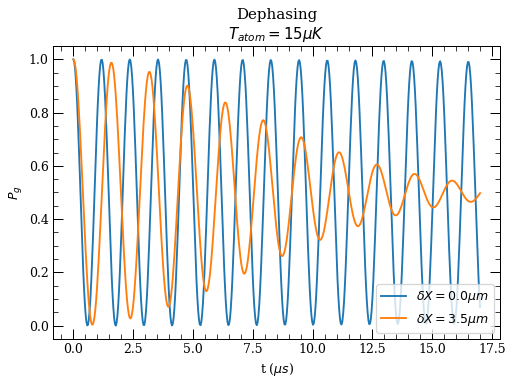

In [141]:
dclock_exp = 0.85e6
dclock_f = 0.63e6
dx = np.sqrt(-np.log(dclock_f/dclock_exp)/2)
print(dx)
fig,ax=plt.subplots(1,1)
for X0b in [0,dx]:
    Ps = [
        P_ri(
            Xs,
            Ys,
            Zs,
            t,
            w_ge*X0b,
            0,
            0,
            dclock_exp
    ).mean() for t in ts
    ]
    ax.plot(ts*1e6,Ps,label=f"$\delta X = {X0b*w_ge*1e6:.1f}\mu m$")
ax.legend()

ax.set_xlabel("t ($\mu s$)")
ax.set_ylabel("$P_g$")
ax.set_title(f"Dephasing\n$T_{{atom}} = {T*1e6:.0f}\mu K$")

fig.tight_layout()
fig.show()

<IPython.core.display.Javascript object>


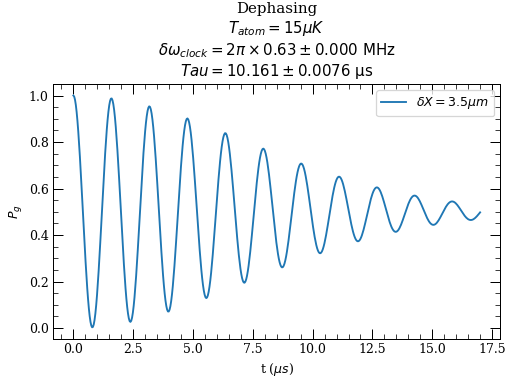

In [142]:
fig,ax=plt.subplots(1,1)
ax.plot(ts*1e6,Ps,label=f"$\delta X = {X0b*w_ge*1e6:.1f}\mu m$")
ax.legend()

ax.set_xlabel("t ($\mu s$)")
ax.set_ylabel("$P_g$")

func = lambda t,f,T: 0.5*(np.cos(2*pi*f*1e6*t)*np.exp(-(t/(T*1e-6))**2)+1)
popt, pcov = curve_fit(func,ts,Ps,p0=[0.63,10])
perr = np.sqrt(np.diag(pcov))

#ax.plot(ts*1e6,func(ts,*popt))
ax.set_title(f"Dephasing\n$T_{{atom}} = {T*1e6:.0f}\mu K$\n$\delta\omega_{{clock}} = 2\pi\\times {popt[0]:.2f}\pm{perr[0]:.3f}~\\rmMHz$\n$Tau={popt[1]:.3f}\pm{perr[1]:.4f}~\\rm \mu s$")

fig.tight_layout()
fig.show()


<IPython.core.display.Javascript object>


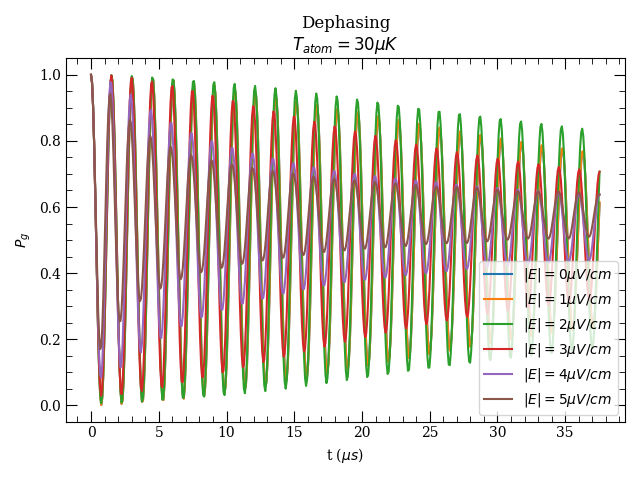

[0. 0. 0. ... 0. 0. 0.]
[37432.94611605 33686.55351232 15803.03945889 ...  4009.30647129
 26321.80969832 88098.00246971]
[149731.78446421 134746.2140493   63212.15783555 ...  16037.22588516
 105287.23879328 352392.00987885]
[336896.51504447 303178.98161092 142227.35512999 ...  36083.75824161
 236896.28728487 792882.02222742]
[ 598927.13785684  538984.85619719  252848.63134221 ...   64148.90354065
  421148.95517311 1409568.03951541]
[ 935823.65290131  842163.83780811  395075.9864722  ...  100232.66178226
  658045.24245798 2202450.06174282]


In [173]:
Eest = 1e-2  # V/m
dist = 14e-3
gradE = lambda E: -2*E/dist
alpha0 = 1664.98e4*1e6  # Hz/(V^2/m^2)

Ddc_rel = lambda x,z,E,theta : alpha0*(x*np.cos(theta)+z*np.sin(theta))*E*gradE(E)

T = 30e-6  # K
X0 = 0

sigX = 0.5*wF*np.sqrt(T/U0)
sigZ = zfF*np.sqrt(T/2/U0)
sigV = np.sqrt(kb*T/mcs)

N = 10000

rnd = np.random.default_rng()
Xs = rnd.normal(0,sigX,N)
Ys = rnd.normal(0,sigX,N)
Zs = rnd.normal(0,sigZ,N)
Vzs = rnd.normal(0,sigV,N)


fig,ax=plt.subplots(1,1)
for Eest in np.arange(0,6e-2,1e-2):
    ang=0
    Ddcs = Ddc_rel(Xs,Zs,Eest,ang)
    Ps = [
        P_gf(
            Xs,
            Ys,
            Zs,
            t,
            1e-6*X0,
            0,
            0,
            Vzs,
            Dac_rel(Xs,Ys,Zs,X0*1e-6,0,0)+Ddcs
        ).mean() for t in ts
    ]
    print(Ddcs)
    ax.plot(ts*1e6,Ps,label=f"$|E| = {Eest*1e2:.0f}\mu V/cm$")
    ax.legend()

ax.set_xlabel("t ($\mu s$)")
ax.set_ylabel("$P_g$")
ax.set_title(f"Dephasing\n$T_{{atom}} = {T*1e6:.0f}\mu K$") #; $|E| = {Eest*1e2:.1f}\mu V/cm$")

fig.tight_layout()
fig.show()

In [142]:
dist = 14e-3  # to m from mm
E = 5e-6*1e2  # to V/m from muV/cm
qest = 4*pi*eps*dist**2*E
Egrad = -2*E/dist

In [143]:
Ddc_rel(Xs,Zs,E,pi/2).mean()

-61.25934324088188

In [144]:
theta=pi/2
(alpha0*(Xs*np.cos(theta)+Zs*np.sin(theta))*E*gradE(E)).mean()

-9.749727287349423

In [145]:
sigZ

7.782944154320367e-06

<IPython.core.display.Javascript object>


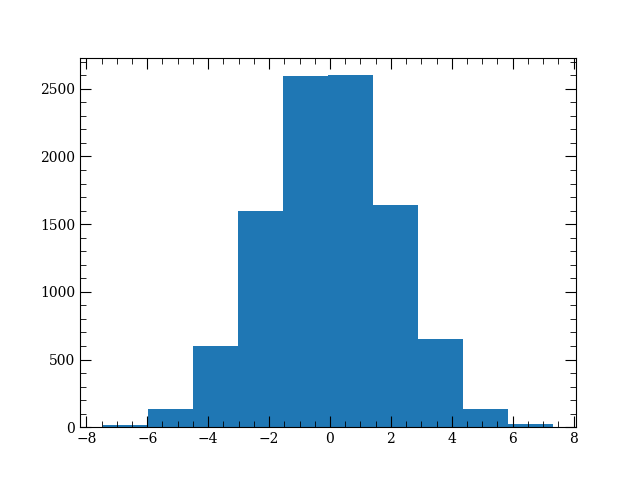

(array([  17.,  137.,  598., 1599., 2595., 2600., 1642.,  648.,  138.,
          26.]),
 array([-7.4676588 , -5.98695424, -4.50624968, -3.02554511, -1.54484055,
        -0.06413598,  1.41656858,  2.89727315,  4.37797771,  5.85868228,
         7.33938684]),
 <BarContainer object of 10 artists>)

In [148]:
fig,ax=plt.subplots(1,1)
ax.hist(Ddc_rel(Xs,Zs,4e-2,0)*1e-6/tau)

<IPython.core.display.Javascript object>


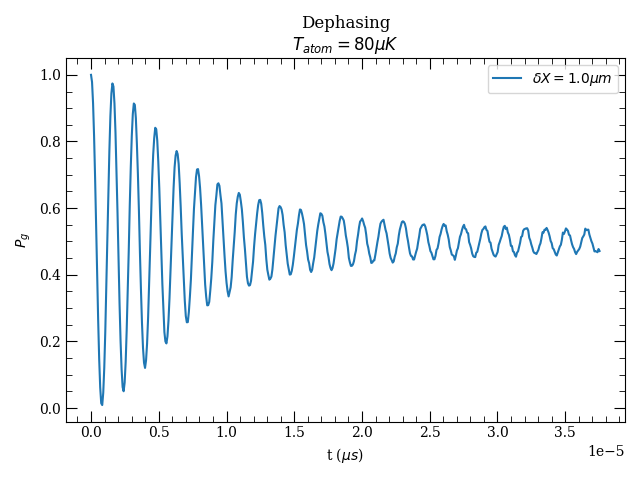

In [169]:

fig,ax=plt.subplots(1,1)


In [45]:
freq(684e-9)/80e6*(sigV/c)

0.0012928383420715633